<a href="https://colab.research.google.com/github/dtabuena/Images/blob/main/Sample_MDGA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install python-bioformats

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import javabridge
import bioformats
import skimage
from skimage import filters
from matplotlib import pyplot as plt
import matplotlib
javabridge.start_vm(class_path=bioformats.JARS)

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


In [30]:
# !wget -O 'image.oir' 'https://www.dropbox.com/s/ec4squfg12j7tm7/RNF182_08-12-22_S001_CA3_40X_2XZOOM_1_.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/8yiynglvcfww3cd/RNF182_08-12-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/ie3v5wdhbahaigj/Nell2_08-04-22_S001_DG_40X_2XZOOM_1.oir?dl=0'
# !wget -O 'image.oir' 'https://www.dropbox.com/s/tf88caoqox1z765/Nell2_08-04-22_S001_CA3_40X_2XZOOM_7.oir?dl=0'
!wget -O 'image.oir' 'https://www.dropbox.com/s/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir?dl=0'



target_name = 'MDGA2'

--2022-09-29 22:57:05--  https://www.dropbox.com/s/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir [following]
--2022-09-29 22:57:05--  https://www.dropbox.com/s/raw/0597gxdoqco3aw6/MDGA2_08-25-22_S001_CA3_40X_2XZOOM_2.oir
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc04f5527b493a0e5c5559b0e04a.dl.dropboxusercontent.com/cd/0/inline/Bt4aPaU6b1D6lR_CiTc5TSo92r7dFBQiW8LkdKNiQE5hK6E5AEs2-m4WsuxR3PFASsJY6xQwOGxq08cRqk1Strl3M68HX_Jut5iYp9Gqg_-xzVlhyLGEdz5YLJI8tGj_2tlLewOpcKX9g9U_2-P4_nacZRmbUujK4VY2d2fZeqjVBA/file# [following]
--2022-09-29 22:57:06--  https://uc04f5527b493a0e5c5559b0e04a.dl.dropboxusercontent.com/cd

In [31]:
my_reader = bioformats.get_image_reader('my_image', 'image.oir')

c_dim = my_reader.rdr.getSizeC()
z_dim = my_reader.rdr.getSizeZ()
x_dim = my_reader.rdr.getSizeX()
y_dim = my_reader.rdr.getSizeY()
print(x_dim,y_dim,c_dim,z_dim)

image = np.empty([x_dim,y_dim,c_dim,z_dim])
for zi in range(z_dim):
    img_zi = my_reader.read(c=None, z=zi,rescale=True)
    image[:,:,:,zi] = img_zi


image_zproj = np.max(image,axis=3)
# image = np.expand_dims(image_zproj, axis=-1)
print(image.shape)
for ci in range(image.shape[2]):
    cim = image[:,:,ci,:]
    flat = cim.flatten()
    max= np.percentile(flat,100)
    assert max>0 , print(flat)
    cim = cim/max
    image[:,:,ci,:] = cim

800 800 3 7
(800, 800, 3, 7)


In [32]:
def new_colormap(start,stop,n=256):
    start = np.array(start)
    stop = np.array(stop)
    delta_ni = np.expand_dims((stop-start)/n,-1)
    ni = np.expand_dims(np.arange(n),-1)
    cmap_np = start + np.multiply(delta_ni.T,ni)
    return matplotlib.colors.ListedColormap(cmap_np)


green_map = new_colormap([0,0,0,1],[0,1,0,1])
red_map = new_colormap([0,0,0,1],[1,0,0,1])
white_map = new_colormap([0,0,0,1],[1,1,1,1])
blue_map = new_colormap([0,0,0,1],[0,0,1,1])

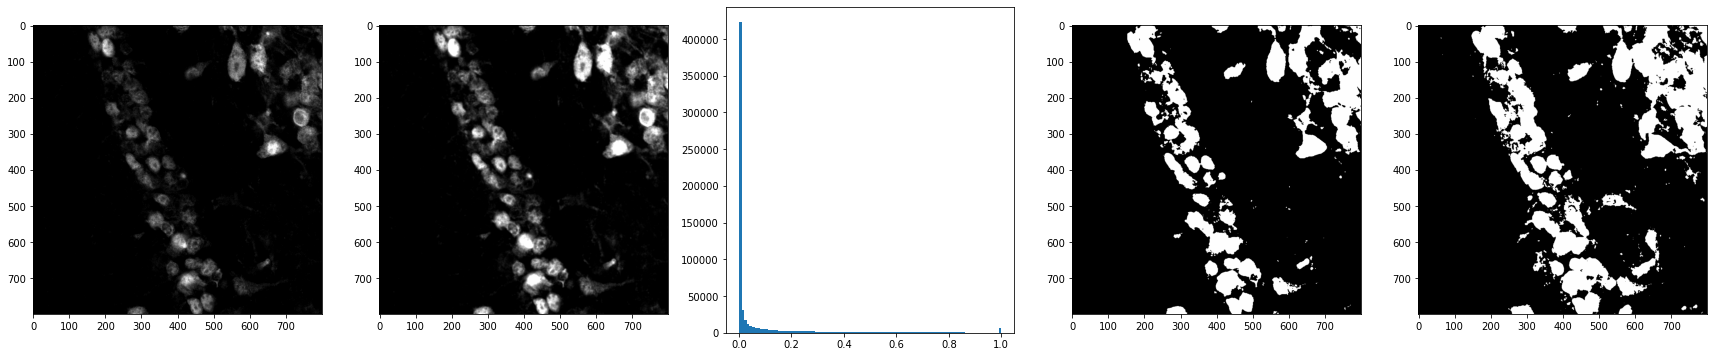

In [33]:
####################### Process NEUN
neun_im = image[:,:,2,:]
m_size = 2
g_sigma_1 = 1
g_sigma_2 = 10
saturation = 99
im_filtered = neun_im.copy()
im_binary= im_filtered.copy()
for zi in range(neun_im.shape[-1]):
    im_zi = neun_im[:,:,zi]
    im_zi = im_zi/np.max(im_zi.flatten())
    im_zi_mf = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    im_zi = skimage.filters.gaussian(im_zi, sigma = g_sigma_1)   #### blur
    im_zi_bk = skimage.filters.gaussian(im_zi, sigma = g_sigma_2)  ### get background from big blur
    # im_zi = im_zi - im_zi_bk
    im_zi = im_zi/np.percentile(im_zi.flatten(),saturation)
    im_zi[im_zi>1]=1
    im_filtered[:,:,zi] = im_zi
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())*.5

neun_im_f = im_filtered
neu_mask_z = im_binary
neu_mask_zp = np.max(neu_mask_z,axis=-1)


sp=2
fig,ax = plt.subplots(1,5,figsize=[30,6])
ax[0].imshow(neun_im[:,:,sp],cmap=white_map)
ax[1].imshow(neun_im_f[:,:,sp],cmap=white_map)
ax[2].hist(neun_im_f[:,:,sp].flatten(),100)
ax[3].imshow(neu_mask_z[:,:,sp],cmap=white_map)
ax[4].imshow(neu_mask_zp,cmap=white_map)


# for ai in ax[[0,1, 3, 4]]:
#     ai.set_xlim(200,500)
#     ai.set_ylim(500,200)
# plt.show()

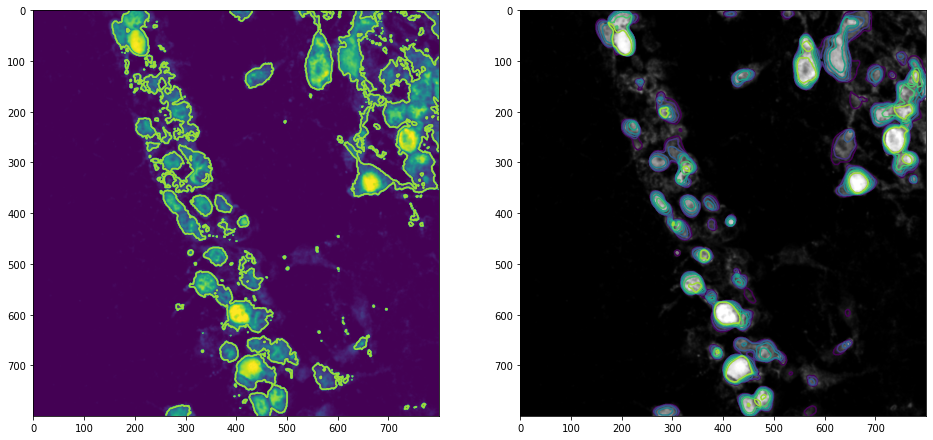

In [34]:
import scipy
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage

min_rad = 10
min_rad
# circ_filt=np.zeros((r*2+1,r*2+1))
mg = np.meshgrid(np.arange(-min_rad,min_rad+1),np.arange(-min_rad,min_rad+1))
circ_filt = (mg[0]**2 + mg[1]**2 <= min_rad**2)*1.

# plt.imshow(circ_filt)
sp=3
i_a =neun_im_f[:,:,sp]
a = neu_mask_z[:,:,sp]
a_f = skimage.filters.median(a*1., selem=circ_filt)
a_f = scipy.signal.convolve2d(a*1., circ_filt,mode='same')/np.sum(circ_filt.flatten())>.35

smoothed_mask = neun_im_f.copy()
for zi in range(neun_im_f.shape[2]):
    smoothed_mask[:,:,zi] = a_f = scipy.signal.convolve2d(neun_im_f[:,:,zi]*1., circ_filt,mode='same')/np.sum(circ_filt.flatten())>.35


fig, ax = plt.subplots(1,2,figsize=[16,8])
ax[0].imshow(np.sum(neun_im_f,axis=-1))
ax[0].contour(a)
ax[1].imshow(np.sum(neun_im_f,axis=-1),cmap='gray')
ax[1].contour(np.sum(smoothed_mask,axis=-1))
# for ai in ax:
#     ai.set_xlim(200,500)
#     ai.set_ylim(500,200)



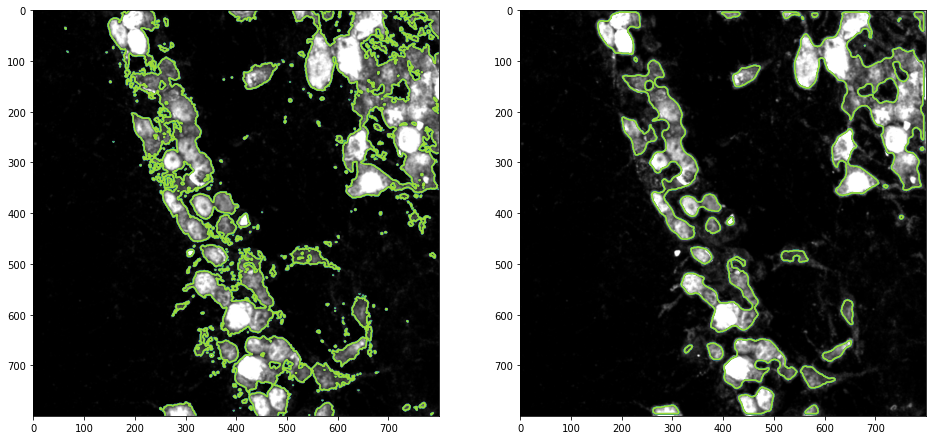

In [21]:
i_max = np.max(neun_im_f,axis=-1)
m_max = np.max(neu_mask_z,axis=-1)

min_rad = 8
mg = np.meshgrid(np.arange(-min_rad,min_rad+1),np.arange(-min_rad,min_rad+1))
circ_filt = (mg[0]**2 + mg[1]**2 <= min_rad**2)*1.
m_max_f = scipy.signal.convolve2d(m_max*1., circ_filt,mode='same')/np.sum(circ_filt.flatten())>.8

fig, ax = plt.subplots(1,2,figsize=[16,8])
ax[0].imshow(i_max,cmap='gray')
ax[0].contour(m_max)

ax[1].imshow(i_max,cmap='gray')
ax[1].contour(m_max_f)

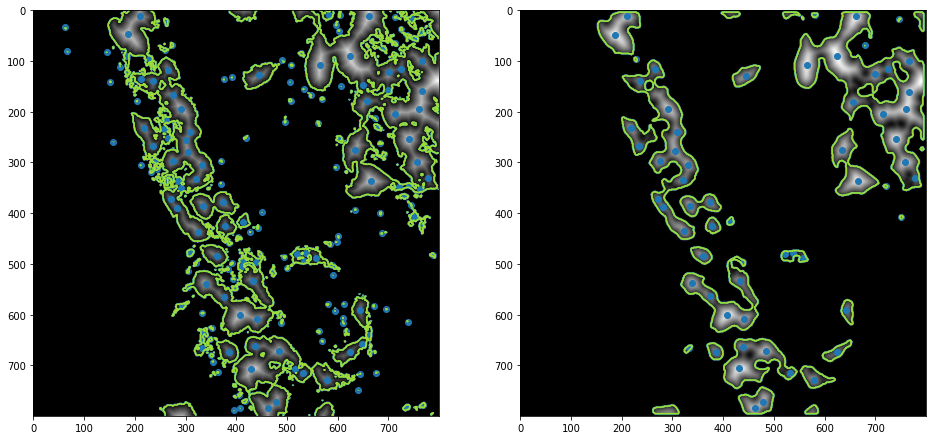

In [29]:
distance = ndimage.distance_transform_edt(m_max)
modified_intent = skimage.filters.gaussian(m_max_f*distance,3)

min_distance = 10
coords_I = peak_local_max(modified_intent, min_distance=min_distance)
coords_D = peak_local_max(distance, min_distance=min_distance)

fig, ax = plt.subplots(1,2,figsize=[16,8])
ax[0].imshow(distance,cmap='gray')
ax[0].contour(m_max)
ax[0].scatter(coords_D[:,1],coords_D[:,0])

ax[1].imshow(modified_intent,cmap='gray')
ax[1].contour(m_max_f)
ax[1].scatter(coords_I[:,1],coords_I[:,0])



(500.0, 200.0)

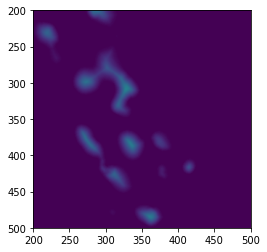

In [146]:

# distance = ndimage.distance_transform_edt(a_f)
dist_stack = smoothed_mask.copy()
for zi in range(smoothed_mask.shape[2]):
    dist_stack[:,:,zi] = ndimage.distance_transform_edt(smoothed_mask[:,:,zi])


plt.imshow(np.sum(dist_stack,axis=-1))
ax =plt.gca()
ax.set_xlim(200,500)
ax.set_ylim(500,200)

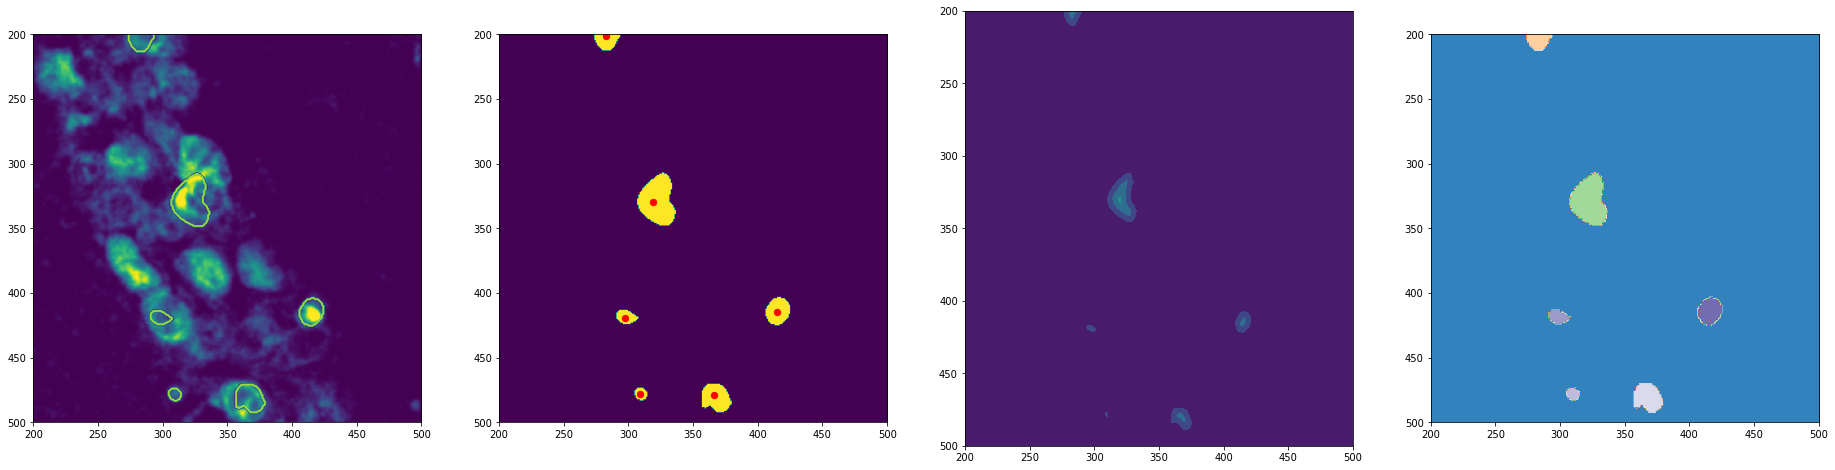

In [148]:
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage
distance = ndimage.distance_transform_edt(a_f)
# fp = 20
coords = peak_local_max(distance, min_distance=25)
mask = np.zeros(distance.shape, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)


b = watershed(-distance, markers, mask=a_f)
num_plot = 4
fig, ax = plt.subplots(1,num_plot,figsize=[8*num_plot,8])
ax[0].imshow(neun_im_f[:,:,sp])
ax[0].contour(a_f)
ax[1].imshow(a_f)
ax[1].scatter(coords[:,1],coords[:,0], c='r', s=40)
ax[2].contourf(distance)
ax[3].imshow(b,cmap='tab20c')
for ai in ax:
    ai.set_xlim(200,500)
    ai.set_ylim(500,200)

(500.0, 200.0)

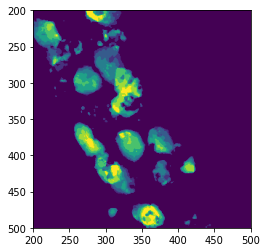

In [22]:
zBin = np.sum(neu_mask_z,axis = -1)
ax = plt.gca()
plt.imshow(zBin)
ax.set_xlim(200,500)
ax.set_ylim(500,200)

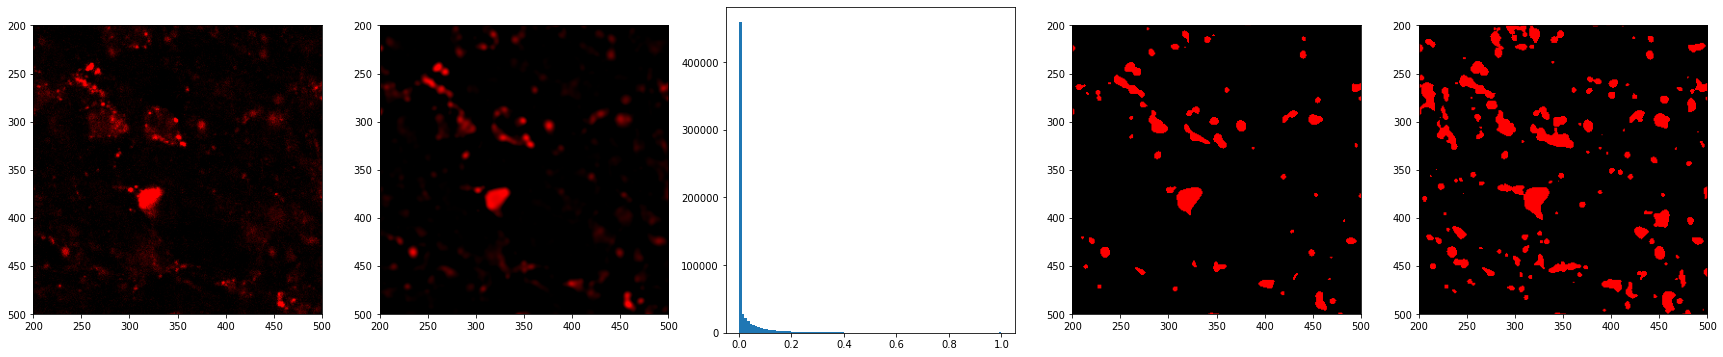

In [7]:
####################### Process mcherry
mcherry_im = image[:,:,1,:]
m_size = 2
g_sigma_1 = 2
g_sigma_2 = 10
saturation = 99.9
im_filtered = mcherry_im.copy()
im_binary = np.zeros_like(im_filtered)
for zi in range(neun_im.shape[-1]):
    im_zi = mcherry_im[:,:,zi]
    im_zi = im_zi/np.max(im_zi.flatten())
    im_zi = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    im_zi = skimage.filters.gaussian(im_zi, sigma = g_sigma_1)   #### blur
    im_zi_bk = skimage.filters.gaussian(im_zi, sigma = g_sigma_2)  ### get background from big blur
    im_zi = im_zi - im_zi_bk
    im_zi[im_zi<0]=0
    im_zi = im_zi/np.percentile(im_zi.flatten(),saturation)
    im_zi[im_zi>1]=1
    im_filtered[:,:,zi] = im_zi
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())



mcherry_im_f = im_filtered
mcherry_mazk_z = im_binary
mcherry_mask_zp = np.max(mcherry_mazk_z,axis=-1)


fig,ax = plt.subplots(1,5,figsize=[30,6])
ax[0].imshow(mcherry_im[:,:,sp],cmap=red_map)
ax[1].imshow(mcherry_im_f[:,:,sp],cmap=red_map)
ax[2].hist(mcherry_im_f[:,:,sp].flatten(),100)
ax[3].imshow(mcherry_mazk_z[:,:,sp],cmap=red_map)
ax[4].imshow(mcherry_mask_zp,cmap=red_map)

for ai in ax[[0,1, 3, 4]]:
    ai.set_xlim(200,500)
    ai.set_ylim(500,200)
plt.show()

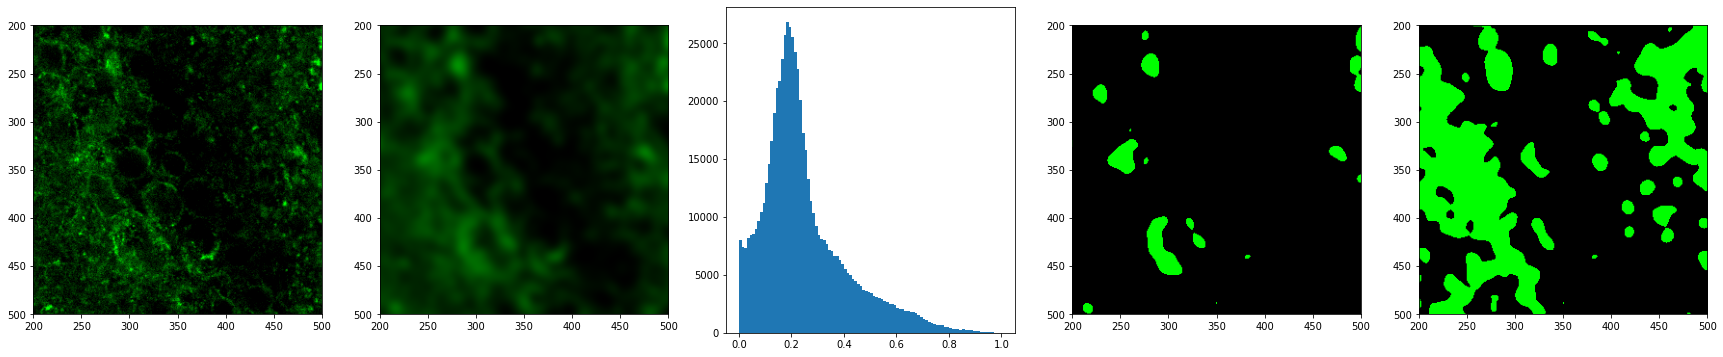

In [8]:
####################### Process CrispTarg
target_im = image[:,:,0,:]
m_size = 3
g_sigma_1 = 5
g_sigma_2 = 15
saturation = 100
im_filtered = target_im.copy()
im_binary = np.zeros_like(im_filtered)
for zi in range(target_im.shape[-1]):
    im_zi = target_im[:,:,zi]
    im_zi = skimage.filters.median(im_zi, selem=np.ones([m_size,m_size]))   #### DeSpeckle
    im_zi = skimage.filters.gaussian(im_zi, sigma = g_sigma_1)   #### blur
    im_zi_bk = skimage.filters.gaussian(im_zi, sigma = g_sigma_2)  ### get background from big blur
    # im_zi = im_zi - im_zi_bk
    # im_zi[im_zi_bs<0]=0
    im_zi = im_zi/np.percentile(im_zi.flatten(),saturation)
    im_filtered[:,:,zi] = im_zi
    im_binary[:,:,zi] = im_filtered[:,:,zi]>filters.threshold_otsu(im_filtered[:,:,zi].flatten())

target_im_f = im_filtered
target_mazk_z = im_binary
target_mask_zp = np.max(im_binary,axis=-1)

sp=1
fig,ax = plt.subplots(1,5,figsize=[30,6])
ax[0].imshow(target_im[:,:,sp],cmap=green_map)
ax[1].imshow(target_im_f[:,:,sp],cmap=green_map)
ax[2].hist(target_im_f[:,:,sp].flatten(),100)
ax[3].imshow(target_mazk_z[:,:,sp],cmap=green_map)
ax[4].imshow(target_mask_zp,cmap=green_map)

for ai in ax[[0,1, 3, 4]]:
    ai.set_xlim(200,500)
    ai.set_ylim(500,200)
plt.show()

In [9]:


# neuronal_mcherry = neuronal_mcherry/np.max(neuronal_mcherry.flatten())
# neuronal_target = neuronal_target/np.max(neuronal_target.flatten())
# neuronal_neun = neuronal_neun/np.max(neuronal_neun.flatten())*2

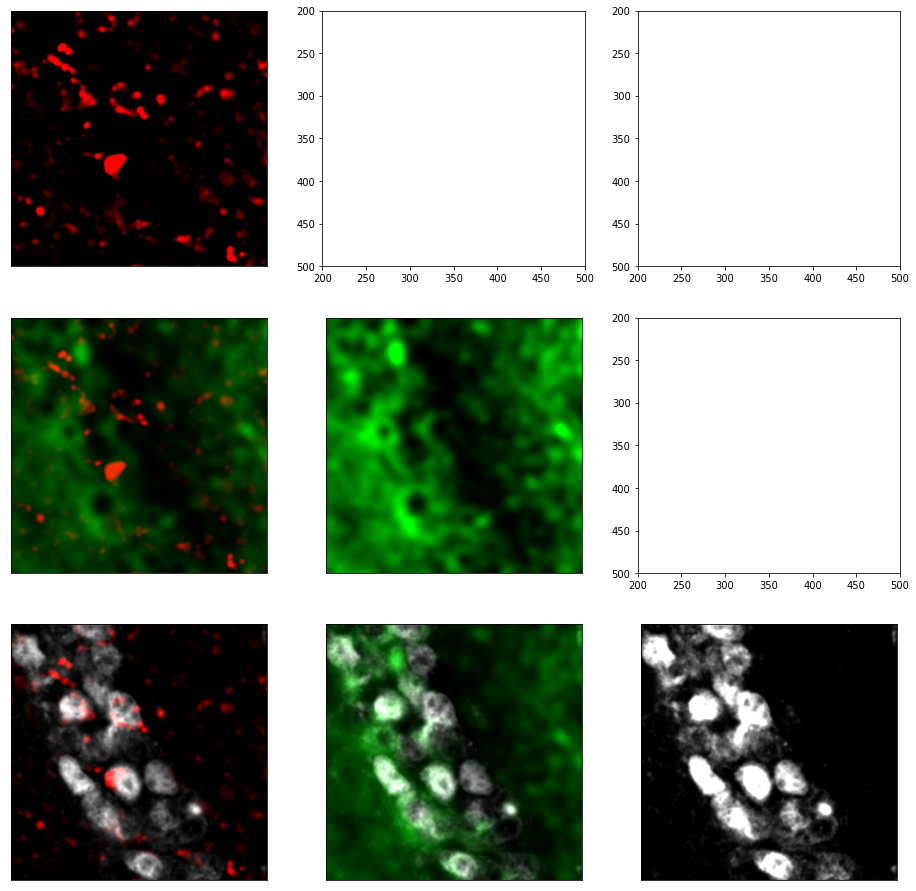

In [10]:
neuronal_mcherry = mcherry_im_f
neuronal_target = target_im_f
neuronal_neun = neun_im_f

sp=2
blanks = np.zeros_like(neuronal_mcherry)
neuronal_mcherry_rgb = np.stack([ neuronal_mcherry, blanks, blanks],axis = -2)
neuronal_target_rgb = np.stack([blanks, neuronal_target, blanks ],axis = -2)
neuronal_neun_rgb = np.stack([neuronal_neun, neuronal_neun, neuronal_neun ],axis = -2)

im_list = [neuronal_mcherry_rgb, neuronal_target_rgb, neuronal_neun_rgb]

fig,ax =plt.subplots(3,3,figsize = [16,16])
for im_i in range(len(im_list)):
    for im_i2 in range(len(im_list)):
        if im_i2>im_i: continue
        im_merge = (im_list[im_i] + im_list[im_i2])
        # im_merge = rgb_cmy(im_merge)*2
        ax[im_i,im_i2].imshow(im_merge[:,:,:,sp])
        ax[im_i,im_i2].get_xaxis().set_visible(False)
        ax[im_i,im_i2].get_yaxis().set_visible(False)


for ai in ax.flatten():
    ai.set_xlim(200,500)
    ai.set_ylim(500,200)
plt.show()

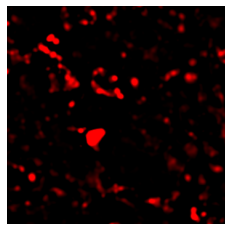

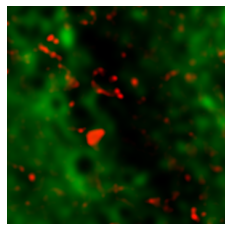

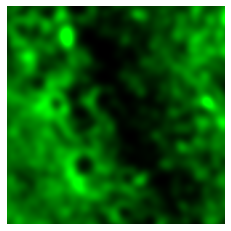

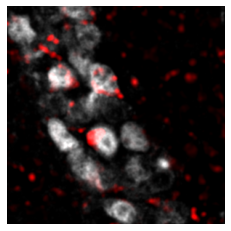

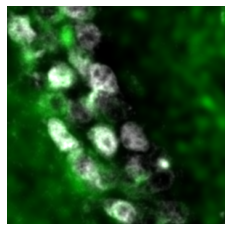

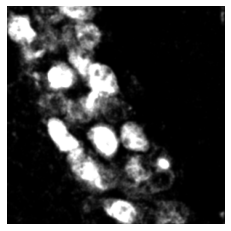

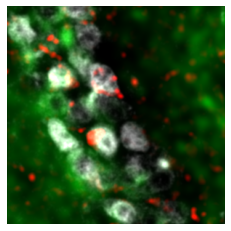

In [11]:
##### Save Samples
label_list = ['mCherry', 'Crispr_Target', 'NeuN']


## Singles and Doubles
for im_i in range(len(im_list)):
    for im_i2 in range(len(im_list)):
        if im_i2>im_i: continue

        
        name = label_list[im_i]+'+'+label_list[im_i2]
        if im_i==im_i2: name = label_list[im_i]

        fig, ax = plt.subplots(1,figsize = [4,4])
        im_merge = (im_list[im_i] + im_list[im_i2])
        
        ax.imshow(im_merge[:,:,:,sp])
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_xlim(200,500)
        ax.set_ylim(500,200)

        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

        fig.savefig(target_name+'_'+name+'.png', bbox_inches='tight')


### Trips
name = label_list[0]+'+'+label_list[1]+'+'+label_list[2]
fig, ax = plt.subplots(1,figsize = [4,4])
im_merge = (im_list[0] + im_list[1]+ im_list[2])

ax.imshow(im_merge[:,:,:,sp])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

ax.set_xlim(200,500)
ax.set_ylim(500,200)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig.savefig(target_name+'_'+name+'.png', bbox_inches='tight')
    

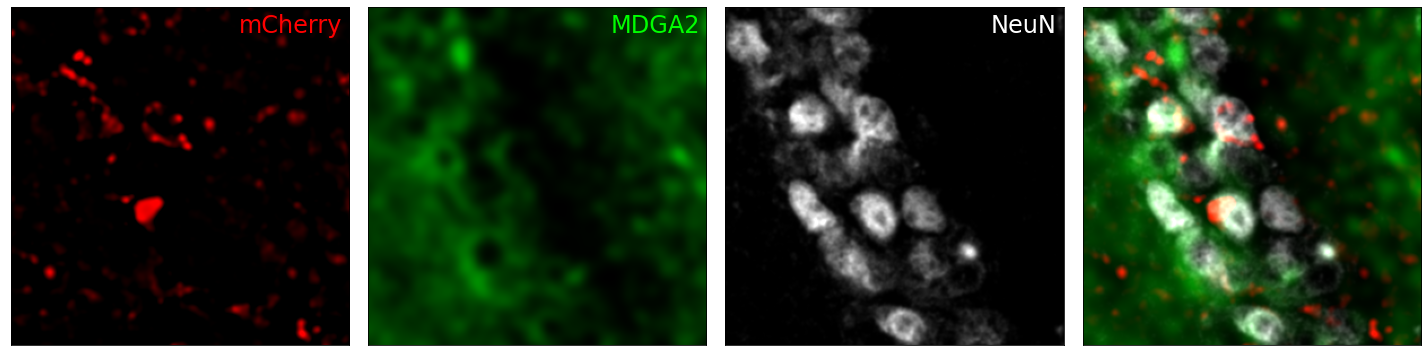

In [12]:
# neuronal_mcherry_rgb = np.stack([ neuronal_mcherry, blanks, blanks],axis = -2)
# neuronal_target_rgb = np.stack([blanks, neuronal_target, blanks ],axis = -2)
# neuronal_neun_rgb = np.stack([neuronal_neun, neuronal_neun, neuronal_neun ],axis = -2)
trip_merge = (im_list[0] + im_list[1]+ im_list[2])


## singles and Trip
fs = 24
fig, ax = plt.subplots(1,4,figsize=[20,5])
ax[0].imshow(neuronal_mcherry_rgb[:,:,:,sp])
ax[0].text(.98, .98, 'mCherry',color='r',transform=ax[0].transAxes,ha='right',va='top',fontsize = fs)
ax[1].imshow(neuronal_target_rgb[:,:,:,sp])
ax[1].text(.98, .98,target_name,color=[0,1,0],transform=ax[1].transAxes,ha='right',va='top',fontsize = fs)
ax[2].imshow(neuronal_neun_rgb[:,:,:,sp])
ax[2].text(.98, .98,'NeuN',color='w',transform=ax[2].transAxes,ha='right',va='top',fontsize = fs)
ax[3].imshow(trip_merge[:,:,:,sp])
for ai in ax.flatten():
    ai.set_xlim(200,500)
    ai.set_ylim(500,200)
    ai.get_xaxis().set_visible(False)
    ai.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()
fig.savefig(target_name+'_grouped'+'.png', bbox_inches='tight')

In [13]:
# import os
# import shutil
# fold_name = 'Results_' + target_name
# fold_name = fold_name.replace(' ','_')
# zip_name= fold_name+'.zip'
# try: os.mkdir(fold_name)
# except: None

# from google import colab
# for root, dirs, files in os.walk("/content"):
#     for f in files:
#         if 'sample_data' in root: continue
#         if 'Results' in root: continue
#         if f.endswith(".png") or f.endswith(".csv"):
#             shutil.copyfile(os.path.join(root,f), os.path.join(root,fold_name,f))

# !zip -r $zip_name $fold_name
# colab.files.download(zip_name)

  adding: Results_MDGA2/ (stored 0%)
  adding: Results_MDGA2/MDGA2_mCherry+Crispr_Target+NeuN.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_NeuN+Crispr_Target.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_mCherry.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_Crispr_Target.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_NeuN.png (deflated 2%)
  adding: Results_MDGA2/MDGA2_NeuN+mCherry.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_grouped.png (deflated 0%)
  adding: Results_MDGA2/MDGA2_Crispr_Target+mCherry.png (deflated 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>